# Sentiment analysis

## Data collection

In [61]:
%reset -f
import time
import DataExtraction as extract
import pandas as pd
import numpy as np
import utils
# import machinealgs as algs
import os
import sys
from sklearn.model_selection import train_test_split, KFold

In [62]:
path = os.getcwd()
directory = path + '\\DATA\\'
## Enter path to data
# path = directory+'AMAZON_FASHION_5.json.gz'
path = directory+'reduced.json.gz'
# path = directory+'Electronics_5.json.gz'
## loading datasets to pandas dataframe
print(path)
df = extract.getDF(path)
df.head()
## For multiple datasets within a directory
# multiDF = extract.process_directory_to_dataframe(directory+'\\split_files\\')
# multiDF

C:\Users\jturn\PycharmProjects\Sentiment_analysis_AMAZON_reviews\DATA\reduced.json.gz


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


In [63]:
print(utils.sentiCounts(df, 'sentiment'))
utils.sentiCounts(df, 'rating')

    overall  count
0  negative   1140
1  positive   8860


,overall,count
0,1,719
1,2,421
2,3,729
3,4,1714
4,5,6417


In [64]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         10000 non-null  float64
 1   vote            1649 non-null   object 
 2   verified        10000 non-null  bool   
 3   reviewTime      10000 non-null  object 
 4   reviewerID      10000 non-null  object 
 5   asin            10000 non-null  object 
 6   style           4214 non-null   object 
 7   reviewerName    9999 non-null   object 
 8   reviewText      9999 non-null   object 
 9   summary         10000 non-null  object 
 10  unixReviewTime  10000 non-null  int64  
 11  image           42 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 8.3 MB


## Text pre-processing

In [70]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Define text preprocessing function
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    # Stem words
    stemmed_words = [stemmer.stem(word) for word in lemmatized_words]
    
    # Join the words back into a single string
    return ' '.join(stemmed_words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jturn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jturn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jturn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [71]:
df['reviewText'] = df['reviewText'].fillna("")

In [72]:
df['reviewText'] = df['reviewText'].apply(preprocess_text)
df['reviewText']

0       best novel read year everyth fiction beauti wr...
1       page page introspect style writer like henri j...
2       kind novel read time lose book day possibl wee...
3       gorgeou languag incred writer last life one be...
4       taken review compar book leopard promis bildun...
                              ...                        
9995      tape great crisp text easi peel back past thing
9996    print label hard time peel back came rippedoff...
9997    black white best easier read white black lette...
9998    amazon link best price great find product half...
9999    price brother label tape amazon gone significa...
Name: reviewText, Length: 10000, dtype: object

## Feature Extraction

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

def get_sentiment(rating):
    if rating <= 2:
        # negative
        return 0
    else:
        # positive
        return 1

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jturn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jturn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jturn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jturn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [76]:
df['sentiment'] = df['overall'].apply(get_sentiment)
# Sample sentences
sentences_series = df["reviewText"].fillna("").apply(str).str.lower()
# Corresponding labels
labels = df['sentiment']

tokenized_sentences = [nltk.word_tokenize(sentence) for sentence in sentences_series]
# Train Word2Vec
word2vec_model = gensim.models.Word2Vec(sentences=tokenized_sentences, vector_size=50, window=5, min_count=1, sg=1)

# Function to compute sentence embeddings
def sentence_to_vector(sentence, model):
    vectors = []
    for word in sentence:
        if word in model.wv:
            vectors.append(model.wv[word])
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Generate Word2Vec sentence embeddings
word2vec_features = np.array([sentence_to_vector(sentence, word2vec_model) for sentence in tokenized_sentences])

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words='english')

# Generate CountVectorizer features
count_vectorizer_features = vectorizer.fit_transform(sentences_series).toarray()

# Combine Word2Vec and CountVectorizer features
combined_features = np.hstack((word2vec_features, count_vectorizer_features))

# Split the combined features and labels into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

## Model training

In [77]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [80]:
%%time
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train, y_train)
# Make predictions
y_pred = rand_forest.predict(X_test)
# Calculate precision, recall, and accuracy
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"Accuracy: {rf_accuracy}")

Precision: 0.8887202832574608
Recall: 1.0
Accuracy: 0.89
CPU times: total: 13.7 s
Wall time: 21.6 s


In [98]:
%%time
grad_boosting = GradientBoostingClassifier()
grad_boosting.fit(X_train, y_train)
# Make predictions
y_pred = grad_boosting.predict(X_test)
# Calculate precision, recall, and accuracy
gb_precision = precision_score(y_test, y_pred)
gb_recall = recall_score(y_test, y_pred)
gb_accuracy = accuracy_score(y_test, y_pred)
print(f"Precision: {gb_precision}")
print(f"Recall: {gb_recall}")
print(f"Accuracy: {gb_accuracy}")

Precision: 0.9081473793461339
Recall: 0.9960159362549801
Accuracy: 0.908
CPU times: total: 2min 4s
Wall time: 4min 8s


In [82]:
%%time
svm = SVC()
svm.fit(X_train, y_train)
# Make predictions
y_pred = svm.predict(X_test)
# Calculate precision, recall, and accuracy
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"Accuracy: {svm_accuracy}")

Precision: 0.8945491594498217
Recall: 0.9994308480364257
Accuracy: 0.896
CPU times: total: 1min 6s
Wall time: 1min 41s


In [101]:
%%time
sgd = SGDClassifier(loss='log_loss', penalty='l2')
sgd.fit(X_train, y_train)
# Make predictions
y_pred = sgd.predict(X_test)
# Calculate precision, recall, and accuracy
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Precision: 0.908195020746888
Recall: 0.9965850882185544
Accuracy: 0.9085
CPU times: total: 1.33 s
Wall time: 2.1 s


### Custom Neural network

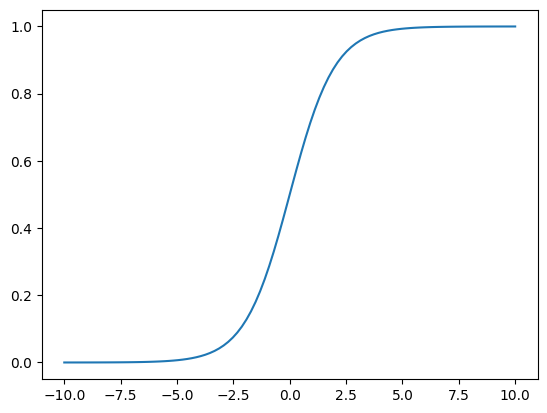

In [84]:
import matplotlib.pyplot as plt
## use a sigmoidal activation function
def activate(x, W, b):
    return 1 / (1 + np.exp(-(x @ W.T + b)))

steepness = 1
position = 0
x = np.linspace(-10, 10, 100)
y = activate(x, steepness * np.identity(100), position)
plt.plot(x, y)

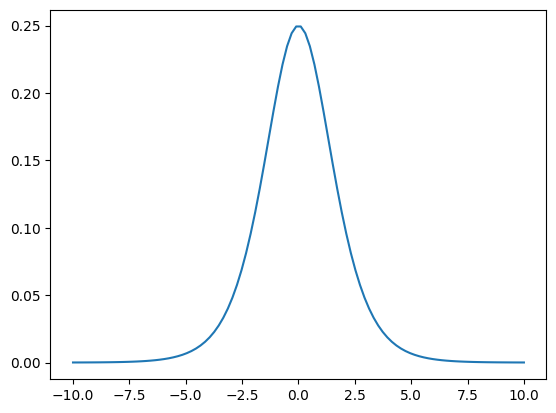

In [85]:
plt.plot(x, y * (1- y))

In [89]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


# Define the sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Derivative of the sigmoid function
def sigmoid_derivative(x):
    return x * (1 - x)


# Define a simple Neural Network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Randomly initialize weights and biases
        self.weights_input_hidden = np.random.uniform(-1, 1, (input_size, hidden_size))  # Correct shape
        self.bias_hidden = np.zeros((1, hidden_size))  # Bias for hidden layer
        self.weights_hidden_output = np.random.uniform(-1, 1, (hidden_size, output_size))  # Correct shape
        self.bias_output = np.zeros((1, output_size))  # Bias for output layer

    # Forward pass
    def forward(self, X):
        # Hidden layer computation
        self.hidden_layer_input = np.dot(X, self.weights_input_hidden) + self.bias_hidden  # Shape: (n_samples, hidden_size)
        self.hidden_layer_output = sigmoid(self.hidden_layer_input)  # Apply sigmoid activation

        # Output layer computation
        self.output_layer_input = np.dot(self.hidden_layer_output, self.weights_hidden_output) + self.bias_output
        self.output_layer_output = sigmoid(self.output_layer_input)  # Apply sigmoid activation

        # Debugging info
        # print("Hidden layer input shape:", self.hidden_layer_input.shape)
        # print("Hidden layer output shape:", self.hidden_layer_output.shape)
        # print("Output layer input shape:", self.output_layer_input.shape)
        # print("Output layer output shape:", self.output_layer_output.shape)

        return self.output_layer_output

    # Backward pass
    def backward(self, X, y, output, learning_rate=0.01):
        # Compute error
        error = y - output  # Expect this to work if y and output are correctly reshaped

        # Compute the output gradient
        output_gradient = error * sigmoid_derivative(output)  # Gradient through sigmoid

        # Gradients for weights and biases
        dW_hidden_output = np.dot(self.hidden_layer_output.T, output_gradient)  # Gradient for weights
        db_output = np.sum(output_gradient, axis=0).reshape(1, -1)  # Reshape bias gradients

        # Hidden layer gradients
        hidden_gradient = np.dot(output_gradient, self.weights_hidden_output.T) * sigmoid_derivative(self.hidden_layer_output)
        dW_input_hidden = np.dot(X.T, hidden_gradient)  # Gradient for weights
        db_hidden = np.sum(hidden_gradient, axis=0).reshape(1, -1)

        # Update weights and biases
        self.weights_hidden_output += learning_rate * dW_hidden_output
        self.bias_output += learning_rate * db_output
        self.weights_input_hidden += learning_rate * dW_input_hidden
        self.bias_hidden += learning_rate * db_hidden

    # Training method
    def train(self, X, y, epochs=50, learning_rate=0.01):
        costs = []  # Record cost over time
        for epoch in range(epochs):
            # Forward pass
            output = self.forward(X)

            # Ensure `y` is reshaped to match the output's shape
            y = y.reshape(-1, 1)  # Reshape target labels to (n_samples, 1) if necessary
            # Backward pass
            self.backward(X, y, output, learning_rate)

            # Compute and record the loss
            loss = np.mean((y - output) ** 2)
            costs.append(np.log10(loss))  # Log scale for better visualization
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

                # Plotting the cost over iterations
        plt.figure(figsize=(8, 6))
        plt.plot(np.arange(len(costs)) * 10000, costs)  # Adjust x-axis to match iterations
        plt.xlabel('Iteration number / 10 000')
        plt.ylabel('log$_{10}$(cost function)')
        plt.title('Cost Function over Training')
        plt.grid()
        plt.show()
        return costs

    # Prediction method
    def predict(self, X):
        output = self.forward(X)
        predictions = (output > 0.5).astype(int)  # Apply threshold for binary classification
        return predictions


X_train shape: (8000, 8675)
y_train shape: (8000,)
Epoch 1/50, Loss: 0.3522
Epoch 2/50, Loss: 0.1121
Epoch 3/50, Loss: 0.1121
Epoch 4/50, Loss: 0.1121
Epoch 5/50, Loss: 0.1121
Epoch 6/50, Loss: 0.1121
Epoch 7/50, Loss: 0.1121
Epoch 8/50, Loss: 0.1121
Epoch 9/50, Loss: 0.1121
Epoch 10/50, Loss: 0.1121
Epoch 11/50, Loss: 0.1121
Epoch 12/50, Loss: 0.1121
Epoch 13/50, Loss: 0.1121
Epoch 14/50, Loss: 0.1121
Epoch 15/50, Loss: 0.1121
Epoch 16/50, Loss: 0.1121
Epoch 17/50, Loss: 0.1121
Epoch 18/50, Loss: 0.1121
Epoch 19/50, Loss: 0.1121
Epoch 20/50, Loss: 0.1121
Epoch 21/50, Loss: 0.1121
Epoch 22/50, Loss: 0.1121
Epoch 23/50, Loss: 0.1121
Epoch 24/50, Loss: 0.1121
Epoch 25/50, Loss: 0.1121
Epoch 26/50, Loss: 0.1121
Epoch 27/50, Loss: 0.1121
Epoch 28/50, Loss: 0.1121
Epoch 29/50, Loss: 0.1121
Epoch 30/50, Loss: 0.1121
Epoch 31/50, Loss: 0.1121
Epoch 32/50, Loss: 0.1121
Epoch 33/50, Loss: 0.1121
Epoch 34/50, Loss: 0.1121
Epoch 35/50, Loss: 0.1121
Epoch 36/50, Loss: 0.1121
Epoch 37/50, Loss: 0.1

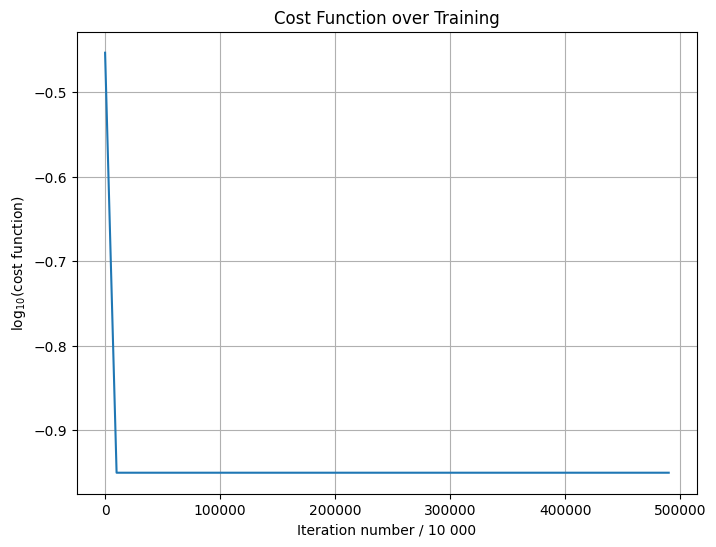

In [90]:
# Ensure the shapes are as expected
print("X_train shape:", X_train.shape)  # Debugging
print("y_train shape:", y_train.shape)  # Debugging

y_train = y_train.to_numpy()

# Instantiate and train the neural network
input_size = X_train.shape[1]  # Number of features from CountVectorizer
hidden_size = 5  # Number of neurons in the hidden layer
output_size = 1  # Single output neuron (binary classification)

nn = NeuralNetwork(input_size, hidden_size, output_size)
nn.train(X_train, y_train, epochs=50, learning_rate=0.1)
y_train = pd.Series(y_train)

In [92]:
y_pred = nn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test data: {accuracy:.2f}")

Accuracy on test data: 0.88


## Improving metrics with Grid Search
The algorithms with the highest accuracy is Stochastic gradient descent and support vector machines. Use grid search to probe further.

**Note: takes too long on my machine (approx 3 hours for each grid search)** 

### SVM gridsearch

In [103]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Define the SVM model
model = SVC(probability=True)

# Define the hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],            # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto']          # Kernel coefficient
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',       # Metric to optimize
    cv=5,                     # 5-fold cross-validation
    verbose=2,                # Verbosity level for logging
    n_jobs=-1                 # Use all available CPU cores
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


KeyboardInterrupt: 

### SGD grid search

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

model = SGDClassifier(random_state=42)
# Define the hyperparameter grid
param_grid = {
    'loss': ['hinge', 'log_loss', 'modified_huber'],  # Loss functions for classification
    'penalty': ['l2', 'l1', 'elasticnet'],           # Regularization types
    'alpha': [0.0001, 0.001, 0.01, 0.1],             # Regularization strength
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],  # Learning rate schedules
    'eta0': [0.01, 0.1, 1],                          # Initial learning rate for 'constant' or 'invscaling'
    'max_iter': [1000, 2000],                        # Maximum number of iterations
}
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',       # Metric to optimize
    cv=5,                     # 5-fold cross-validation
    verbose=2,                # Verbosity level
    n_jobs=-1                 # Use all available CPU cores
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

## Model Evalutation

Model identified was the **SGDClassifier(loss='log_loss', penalty='l2')**

In [104]:
%%time
sgd = SGDClassifier(loss='log_loss', penalty='l2')
sgd.fit(X_train, y_train)
# Make predictions
y_pred = sgd.predict(X_test)
# Calculate precision, recall, and accuracy
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Precision: 0.9280692266089778
Recall: 0.9766647694934547
Accuracy: 0.913
CPU times: total: 1.48 s
Wall time: 2.61 s


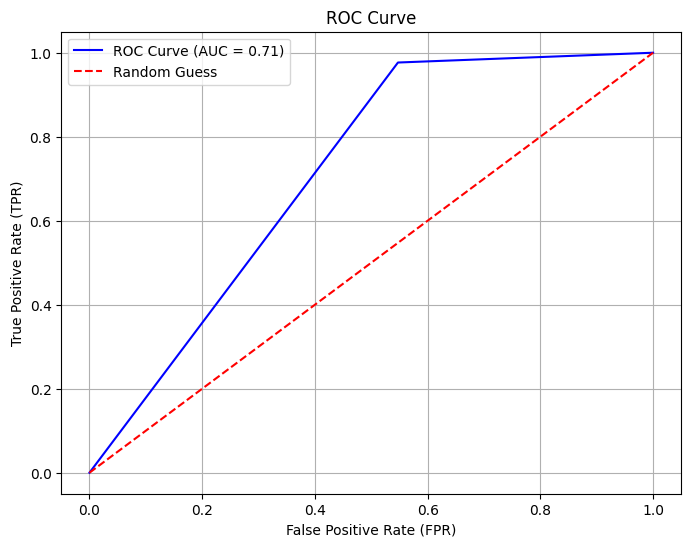

ROC curve saved to C:\Users\jturn\PycharmProjects\Sentiment_analysis_AMAZON_reviews\savedModels\ROC\roc_curve.png


In [114]:
from sklearn.metrics import roc_curve, roc_auc_score
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Compute AUC
auc_score = roc_auc_score(y_test, y_pred)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()

# Save the plot to a file
save_path = os.getcwd()
save_path = save_path+'\\savedModels\\'
roc_path = save_path+'ROC\\roc_curve.png'
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print("ROC curve saved to "+save_roc+'\\savedModels\\ROC\\roc_curve.png')

## Saving the model

In [122]:
import pickle
# # save the model to disk
model_filename = save_path+'model\\SGD_model.sav'
pickle.dump(sgd, open(model_filename, 'wb'))
print("Model saved!")

Model saved!
